In [64]:
import photutils, astropy
from photutils import datasets
from astropy.modeling.functional_models import Sersic2D

import numpy as np
import matplotlib.pyplot as plt

from astropy import visualization, convolution, stats

from collections import OrderedDict

import time

import ashd

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord

import subprocess

%matplotlib inline

In [66]:
def ds9me(val): subprocess.Popen(["ds9", val])

plt.rcParams['figure.figsize'] = [15, 15]

norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())

In [2]:
butler = ashd.Butler(data_dir="/run/media/me/DATA/asas-sn-images")

In [67]:
coord = SkyCoord("02h39m59.3s −34d26m57s")
imgn = butler.get_image_fn(ra=coord.ra.deg,dec=coord.dec.deg)
ds9me(imgn)

In [60]:
img = fits.open(imgn)
data = img[0].data

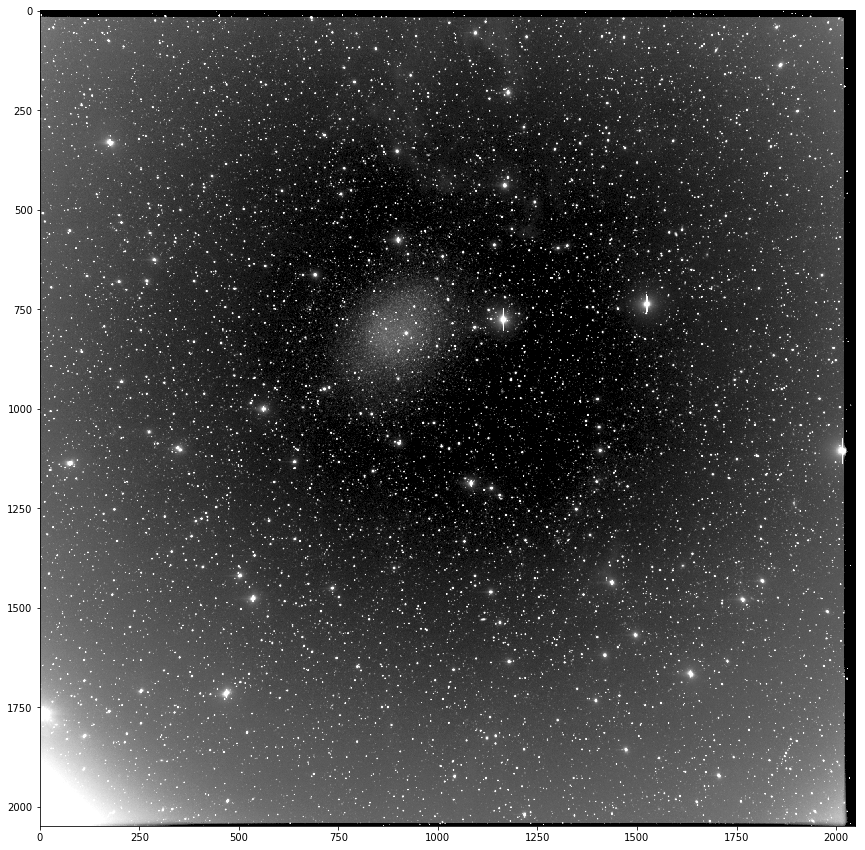

In [63]:
vmin, vmax = np.percentile(data, [10, 99])
plt.imshow(data, cmap="Greys_r", norm=norm, vmin=vmin, vmax=vmax)

Max: 533175.0


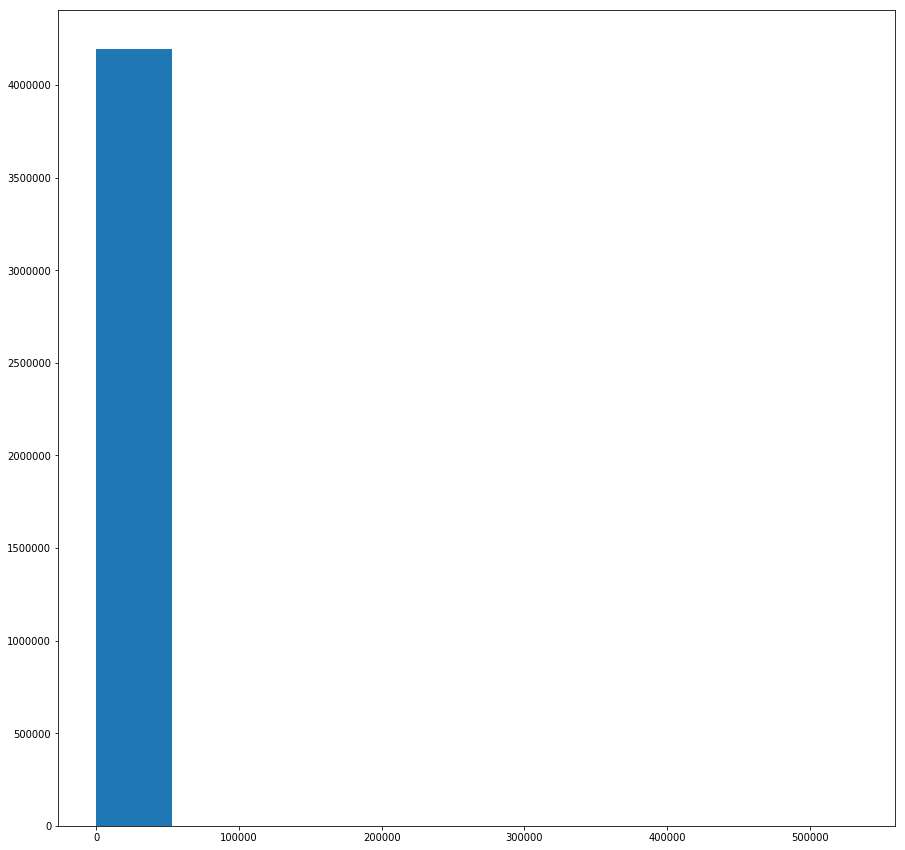

In [68]:
NBINS = 1000
print(f'Max: {np.max(data)}')
histogram = plt.hist(img[0].data.flatten())